In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys 
# sys.path.append("/Users/julianganzabal/facultad/lab-ml/mllab-tools")
from RNN_utils import example_to_io_pairs, to_one_hot_vector, sample, example_to_io
from fnn_helper import PlotLosses

Using TensorFlow backend.


# Formas diferentes de entrenar una RNN con el mismo dataset

## Objetivos:

Comprender los siguientes conceptos:
- Diferencias entre MLP (con features igual a timesteps) y RNN
- Stateful vs stateles en Keras
- Mini-Batch traininig vs SGD training
- Los pesos se actualizan en el backward mientras que el estado de la RNN cambia con cada timestep en el forward
- Padding
- Masking

## Selección de dataset (frase) y preformateo

# IMPORTANTE: En estos ejemplos la idea no es generalizar si no ajustarse lo mejor posible al training

### Elegimos una frase que tenga una letras repetidas

In [2]:
text="MACHINE LEARNING"

In [3]:
chars = sorted(set(text))
print('Caracteres distintos: ', chars)

Caracteres distintos:  [' ', 'A', 'C', 'E', 'G', 'H', 'I', 'L', 'M', 'N', 'R']


In [4]:
chars_to_indices = dict((c, i) for i, c in enumerate(chars))  # map each unique character to unique integer
indices_to_chars = dict((i, c) for i, c in enumerate(chars))

In [5]:
chars_to_indices

{' ': 0,
 'A': 1,
 'C': 2,
 'E': 3,
 'G': 4,
 'H': 5,
 'I': 6,
 'L': 7,
 'M': 8,
 'N': 9,
 'R': 10}

In [6]:
indices_to_chars

{0: ' ',
 1: 'A',
 2: 'C',
 3: 'E',
 4: 'G',
 5: 'H',
 6: 'I',
 7: 'L',
 8: 'M',
 9: 'N',
 10: 'R'}

### Texto a One-hot

In [7]:
window_size=1
one_hot_text = to_one_hot_vector(
    example=text, 
    possible_elements=chars, 
    element_to_indices=chars_to_indices, 
    window_size=window_size
)
print('Vector: ' , one_hot_text, '\nShape: ', one_hot_text.shape)

Vector:  [[[0 0 0 0 0 0 0 0 1 0 0]
  [0 1 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 1 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0 0 0 0 0]]] 
Shape:  (1, 16, 11)


### One-hot a caracter

In [8]:
[indices_to_chars[np.argmax(one_hot_text[0][i])] for i in range(len(text))]

['M',
 'A',
 'C',
 'H',
 'I',
 'N',
 'E',
 ' ',
 'L',
 'E',
 'A',
 'R',
 'N',
 'I',
 'N',
 'G']

## Ejemplo 1: T = 1
En este ejemplo usaremos una RNN pero como una simple vanilla network (MLP)

### Preparo entrada/salida:  

In [9]:
example_to_io(text, input_window_size=1, input_step_size=1)

(['M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A', 'R', 'N', 'I', 'N'],
 ['A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A', 'R', 'N', 'I', 'N', 'G'])

In [10]:
window_size = 1
step_size = 1

# encode_io_pairs llama a window_transform_text y despues codifica en one-hot
X, y = example_to_io_pairs(text, chars, window_size, step_size)

In [11]:
print('X:', X.shape, 'y:', y.shape)

X: (15, 1, 11) y: (15, 11)


In [12]:
print('N: ', X.shape[0])
print('T: ', X.shape[1])
print('D: ', X.shape[2])

N:  15
T:  1
D:  11


In [13]:
for xi in X: print(xi, indices_to_chars[np.argmax(xi)])

[[0 0 0 0 0 0 0 0 1 0 0]] M
[[0 1 0 0 0 0 0 0 0 0 0]] A
[[0 0 1 0 0 0 0 0 0 0 0]] C
[[0 0 0 0 0 1 0 0 0 0 0]] H
[[0 0 0 0 0 0 1 0 0 0 0]] I
[[0 0 0 0 0 0 0 0 0 1 0]] N
[[0 0 0 1 0 0 0 0 0 0 0]] E
[[1 0 0 0 0 0 0 0 0 0 0]]  
[[0 0 0 0 0 0 0 1 0 0 0]] L
[[0 0 0 1 0 0 0 0 0 0 0]] E
[[0 1 0 0 0 0 0 0 0 0 0]] A
[[0 0 0 0 0 0 0 0 0 0 1]] R
[[0 0 0 0 0 0 0 0 0 1 0]] N
[[0 0 0 0 0 0 1 0 0 0 0]] I
[[0 0 0 0 0 0 0 0 0 1 0]] N


In [14]:
for yi in y: print(yi, indices_to_chars[np.argmax(yi)])

[0 1 0 0 0 0 0 0 0 0 0] A
[0 0 1 0 0 0 0 0 0 0 0] C
[0 0 0 0 0 1 0 0 0 0 0] H
[0 0 0 0 0 0 1 0 0 0 0] I
[0 0 0 0 0 0 0 0 0 1 0] N
[0 0 0 1 0 0 0 0 0 0 0] E
[1 0 0 0 0 0 0 0 0 0 0]  
[0 0 0 0 0 0 0 1 0 0 0] L
[0 0 0 1 0 0 0 0 0 0 0] E
[0 1 0 0 0 0 0 0 0 0 0] A
[0 0 0 0 0 0 0 0 0 0 1] R
[0 0 0 0 0 0 0 0 0 1 0] N
[0 0 0 0 0 0 1 0 0 0 0] I
[0 0 0 0 0 0 0 0 0 1 0] N
[0 0 0 0 1 0 0 0 0 0 0] G


Notar que la salida es el siguiente caracter al de la entrada

Esto es equivalente a un MLP

### Armo modelo RNN

In [15]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential

In [16]:
model = Sequential()
sequence_len=len(chars)
rnn_neurons=10
dense_neurons=sequence_len
model.add(SimpleRNN(rnn_neurons, input_shape=(window_size, sequence_len)))
model.add(Dense(dense_neurons, activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 11)                121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


### Entreno el modelo

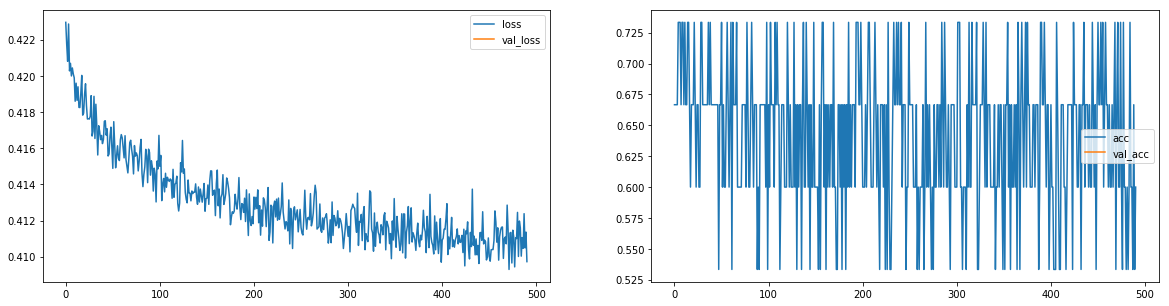

Epoch 492/500
15/15 [==============================] - 0s 3ms/step - loss: 0.4100 - acc: 0.6667
Epoch 493/500
15/15 [==============================] - 0s 4ms/step - loss: 0.4117 - acc: 0.6667
Epoch 494/500
15/15 [==============================] - 0s 3ms/step - loss: 0.4118 - acc: 0.6000
Epoch 495/500
15/15 [==============================] - 0s 3ms/step - loss: 0.4117 - acc: 0.6000
Epoch 496/500
15/15 [==============================] - 0s 3ms/step - loss: 0.4113 - acc: 0.6000
Epoch 497/500
15/15 [==============================] - 0s 3ms/step - loss: 0.4105 - acc: 0.6000
Epoch 498/500
15/15 [==============================] - 0s 3ms/step - loss: 0.4112 - acc: 0.7333
Epoch 499/500
15/15 [==============================] - 0s 3ms/step - loss: 0.4099 - acc: 0.6667
Epoch 500/500
15/15 [==============================] - 0s 3ms/step - loss: 0.4098 - acc: 0.6667


In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    X,
    y,
    epochs=500,
    batch_size=1,
    verbose=1,
    callbacks=[PlotLosses(plot_interval=10, evaluate_interval=None)]
)

Por que no llega al 100%? Que es lo que no puede predecir?

### Predicción usando argmax (Greedy Search)

In [52]:
first_char = text[0]
print('Input:' , first_char)

one_hot_vector = to_one_hot_vector(
    char_to_predict, 
    chars, 
    chars_to_indices,
    window_size
)
prediction = model.predict(one_hot_vector)

print(
    'Predicted Char:',
    indices_to_chars[np.argmax(predicted)], 
    ' (Probability:', np.max(predicted) * 100, '%)'
)

Input: M
Predicted Char: A  (Probability: 99.59898591041565 %)


In [61]:
chars_to_predict = text
print(chars_to_predict)

# Los paso a one hot
to_predict = to_one_hot_vector(
    chars_to_predict, 
    possible_elements=chars, 
    element_to_indices=chars_to_indices, 
    window_size=window_size
)

print(to_predict)
print(to_predict.shape)

MACHINE LEARNING
[[[0 0 0 0 0 0 0 0 1 0 0]
  [0 1 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 1 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0 0 0 0 0]]]
(1, 16, 11)


In [62]:
# Tengo que hacer reshape para darselo a la red
to_predict_reshaped = to_predict.reshape(
    to_predict.shape[1],
    to_predict.shape[0],
    to_predict.shape[2]
)

print(to_predict_reshaped)
print(to_predict_reshaped.shape)

[[[0 0 0 0 0 0 0 0 1 0 0]]

 [[0 1 0 0 0 0 0 0 0 0 0]]

 [[0 0 1 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 1 0 0 0 0 0]]

 [[0 0 0 0 0 0 1 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 1 0]]

 [[0 0 0 1 0 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 1 0 0 0]]

 [[0 0 0 1 0 0 0 0 0 0 0]]

 [[0 1 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 1]]

 [[0 0 0 0 0 0 0 0 0 1 0]]

 [[0 0 0 0 0 0 1 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 1 0]]

 [[0 0 0 0 1 0 0 0 0 0 0]]]
(16, 1, 11)


### Matriz de transición

In [114]:
predicted = model.predict(to_predict_reshaped)

show_results(input, predicted, chars_to_indices, indices_to_chars)

(16, 11)

   _    A    C    E    G    H    I    L    M    N    R    
M [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ] A
A [0.   0.   0.49 0.   0.   0.   0.   0.   0.   0.   0.5 ] R
C [0.   0.   0.   0.   0.   0.99 0.   0.   0.   0.   0.  ] H
H [0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.   0.  ] I
I [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ] N
N [0.   0.   0.   0.33 0.32 0.   0.33 0.   0.   0.   0.  ] I
E [0.5  0.49 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]  
  [0.   0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.  ] L
L [0.   0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.  ] E
E [0.5  0.49 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]  
A [0.   0.   0.49 0.   0.   0.   0.   0.   0.   0.   0.5 ] R
R [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ] N
N [0.   0.   0.   0.33 0.32 0.   0.33 0.   0.   0.   0.  ] I
I [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ] N
N [0.   0.   0.   0.33 0.32 0.   0.33 0.   0.   0.   0.  ] I
G [0.03 0.15 0.1

Que pasa con la A, la E y la N cuando el texto es MACHINE LEARNING

## Ejemplo 2: T = 2

### Preparo entrada/salida

In [22]:
window_size = 2
x_2_t, y_2_t = window_transform_text(text, window_size, step_size)
for i, te in enumerate(x_2_t):
    print(te, '->' ,y_2_t[i])
#print(x_2_t, y_2_t)
X_2, y_2 = encode_io_pairs(text, chars, window_size, step_size)

MA -> C
AC -> H
CH -> I
HI -> N
IN -> E
NE ->  
E  -> L
 L -> E
LE -> A
EA -> R
AR -> N
RN -> I
NI -> N
IN -> G


In [23]:
print(X_2.shape, X_2*1)

(14, 2, 11) [[[0 0 0 0 0 0 0 0 1 0 0]
  [0 1 0 0 0 0 0 0 0 0 0]]

 [[0 1 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0]]

 [[0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0]]

 [[0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0]]

 [[0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0]]

 [[0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 1 0 0 0 0 0 0 0]]

 [[0 0 0 1 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0]]

 [[0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0]]

 [[0 0 0 1 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0]]

 [[0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1]]

 [[0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 1 0]]

 [[0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 1 0 0 0 0]]

 [[0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0]]]


In [24]:
print(y_2*1)

[[0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0]]


### Armo modelo

In [25]:
model_2 = Sequential()
model_2.add(SimpleRNN(10, input_shape=(window_size,len(chars))))
model_2.add(Dense(len(chars), activation="softmax"))
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 10)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 11)                121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


### Entreno modelo

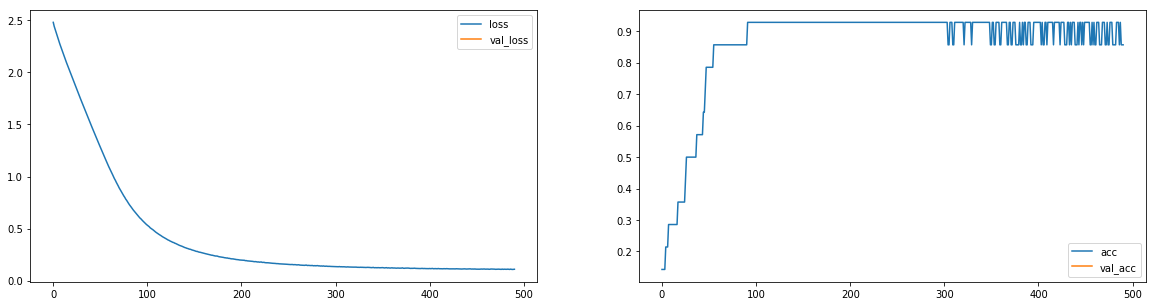

Epoch 492/500
14/14 [==============================] - 0s 3ms/step - loss: 0.1100 - acc: 0.9286
Epoch 493/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1108 - acc: 0.8571
Epoch 494/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1103 - acc: 0.9286
Epoch 495/500
14/14 [==============================] - 0s 3ms/step - loss: 0.1083 - acc: 0.9286
Epoch 496/500
14/14 [==============================] - 0s 3ms/step - loss: 0.1100 - acc: 0.9286
Epoch 497/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1102 - acc: 0.8571
Epoch 498/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1104 - acc: 0.8571
Epoch 499/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1084 - acc: 0.9286
Epoch 500/500
14/14 [==============================] - 0s 4ms/step - loss: 0.1084 - acc: 0.9286


In [26]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_2.fit(X_2,y_2, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

### Matriz de transición

In [27]:
predicted = model_2.predict(X_2)
print(predicted.shape)
print('    ', end='')
for c in chars_to_indices.keys():
    print(c, end='    ')
print()
for i, row in enumerate(predicted):
    print(indices_to_chars[np.argmax(X_2[i, :][0])]+indices_to_chars[np.argmax(X_2[i, :][1])], (row*100).astype(int)/100, indices_to_chars[np.argmax(row)])

(14, 11)
         A    C    E    G    H    I    L    M    N    R    
MA [0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ] C
AC [0.   0.   0.   0.   0.   0.98 0.   0.   0.   0.   0.  ] H
CH [0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.   0.  ] I
HI [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ] N
IN [0.   0.   0.   0.5  0.48 0.   0.   0.   0.   0.   0.  ] E
NE [0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]  
E  [0.   0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.  ] L
 L [0.   0.   0.   0.97 0.01 0.   0.   0.   0.   0.   0.  ] E
LE [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ] A
EA [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.98] R
AR [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ] N
RN [0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.   0.  ] I
NI [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ] N
IN [0.   0.   0.   0.5  0.48 0.   0.   0.   0.   0.   0.  ] E


Notar que luego de IN no se puede tener certeza debido a la ambiguedad

- Como es de esperar la predicción mejora notablemente
- La cantidad de parametros de la red no cambia respecto a la anterior
- Que pasa si lo implemento con MLP con la cantidad de parámetros?

## Ejemplo 3: T = 3

### Preparo entrada/salida

In [28]:
window_size = 3
x_3_t, y_3_t = window_transform_text(text, window_size, step_size)
for i, te in enumerate(x_3_t):
    print(te, '->' ,y_3_t[i])
#print(x_2_t, y_2_t)
X_3, y_3 = encode_io_pairs(text, chars, window_size, step_size)

MAC -> H
ACH -> I
CHI -> N
HIN -> E
INE ->  
NE  -> L
E L -> E
 LE -> A
LEA -> R
EAR -> N
ARN -> I
RNI -> N
NIN -> G


### Armo modelo

In [29]:
model_3 = Sequential()
model_3.add(SimpleRNN(10, input_shape=(window_size,len(chars))))
model_3.add(Dense(len(chars), activation="softmax"))
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 10)                220       
_________________________________________________________________
dense_3 (Dense)              (None, 11)                121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


### Entreno modelo

Cambiar batch_size y verificar que converge de la misma manera

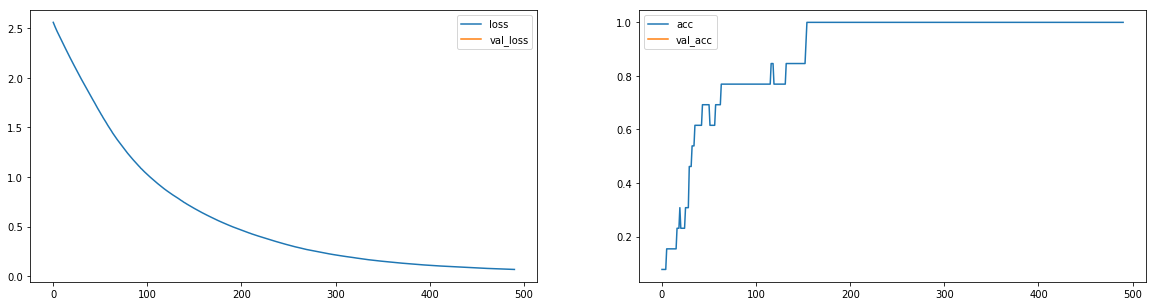

Epoch 492/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0662 - acc: 1.0000
Epoch 493/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0659 - acc: 1.0000
Epoch 494/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0656 - acc: 1.0000
Epoch 495/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0652 - acc: 1.0000
Epoch 496/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0649 - acc: 1.0000
Epoch 497/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0646 - acc: 1.0000
Epoch 498/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0643 - acc: 1.0000
Epoch 499/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0640 - acc: 1.0000
Epoch 500/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0637 - acc: 1.0000


In [30]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_3.fit(X_3,y_3, epochs=500, batch_size=4, verbose=1, callbacks=[plot_losses])

- Como funciona la RNN con un batch size mayor que 1?
- En que momento se resetea el estado?
- Que dimensión tendrá el vector de estados durante el entrenamiento?

### Matriz de transición

In [31]:
predicted = model_3.predict(X_3)
print(predicted.shape)
print('     ', end='')
for c in chars_to_indices.keys():
    print(c, end='    ')
print()
for i, row in enumerate(predicted):
    print(indices_to_chars[np.argmax(X_3[i, :][0])]+
          indices_to_chars[np.argmax(X_3[i, :][1])]+
          indices_to_chars[np.argmax(X_3[i, :][2])], 
          (row*100).astype(int)/100, indices_to_chars[np.argmax(row)])

(13, 11)
          A    C    E    G    H    I    L    M    N    R    
MAC [0.   0.01 0.   0.03 0.   0.92 0.   0.   0.   0.   0.01] H
ACH [0.   0.   0.   0.   0.   0.   0.98 0.   0.   0.   0.  ] I
CHI [0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.97 0.  ] N
HIN [0.01 0.   0.   0.92 0.01 0.   0.   0.   0.   0.03 0.  ] E
INE [0.89 0.01 0.   0.02 0.02 0.   0.   0.01 0.   0.01 0.  ]  
NE  [0.01 0.   0.   0.   0.01 0.   0.   0.93 0.   0.   0.  ] L
E L [0.01 0.   0.   0.95 0.   0.   0.   0.   0.   0.02 0.  ] E
 LE [0.01 0.93 0.   0.   0.01 0.02 0.   0.   0.   0.   0.  ] A
LEA [0.   0.   0.   0.   0.   0.01 0.01 0.   0.   0.02 0.92] R
EAR [0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.95 0.  ] N
ARN [0.   0.   0.   0.   0.01 0.   0.97 0.   0.   0.   0.  ] I
RNI [0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.97 0.  ] N
NIN [0.03 0.02 0.   0.02 0.86 0.   0.01 0.01 0.   0.   0.  ] G


- Las probabilidades son practicamente 1
- La cantidad de parametros de la red no cambia respecto a la anterior
- Que pasa si lo implemento con MLP con la cantidad de parámetros?

### Redefino Modelo con pesos aprendidos pero statefull
Cargo los pesos aprendidos y la evaluo en modo statefull

In [32]:
batch_size=1
model_3s = Sequential()
model_3s.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_3s.add(Dense(len(chars), activation="softmax"))
model_3s.summary()
model_3s.set_weights(model_3.get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (1, 10)                   220       
_________________________________________________________________
dense_4 (Dense)              (1, 11)                   121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [33]:
window_size=1
model_3s.reset_states()
input_char = text[0]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='    ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

char de entrada: M
        A    C    E    G    H    I    L    M    N    R    
[[0.03 0.01 0.01 0.35 0.03 0.26 0.03 0.05 0.01 0.12 0.06]]
char predicted: E


Notar que con un solo caracter ingresado, no tiene suficiente data para predecir (Ningun caracter tiene alta probabilidad)

In [34]:
input_char = text[1]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('  ', end='')
for c in chars_to_indices.keys():
    print(c, end='    ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

char de entrada: A
       A    C    E    G    H    I    L    M    N    R    
[[0.01 0.01 0.   0.24 0.   0.66 0.   0.01 0.01 0.01 0.02]]
char predicted: H


la predicción no tiene por que ser correcta a esta altura debido a que el modelo nunca fue entrenado con la secuencia ingresada

In [35]:
input_char = text[2]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='    ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

char de entrada: C
        A    C    E    G    H    I    L    M    N    R    
[[0.   0.01 0.   0.03 0.   0.92 0.   0.   0.   0.   0.01]]
char predicted: H


Notar que luego de la tercer predicción el modelo predice casi perfectamente

In [36]:
input_char = text[3]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='    ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

char de entrada: H
        A    C    E    G    H    I    L    M    N    R    
[[0.   0.01 0.   0.03 0.   0.81 0.03 0.   0.   0.01 0.07]]
char predicted: H


Notar como suele bajar la probabilidad de la predicción debido a que el modelo no tiene por que predecir secuencias mayores a la longitud entrenada (Aunque en ciertas circunstancias podría generalizar)

In [37]:
input_char = text[4]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

char de entrada: I
         A     C     E     G     H     I     L     M     N     R     
[[0.   0.   0.   0.49 0.   0.4  0.   0.   0.   0.05 0.02]]
char predicted: E


In [38]:
input_char = text[5]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

char de entrada: N
         A     C     E     G     H     I     L     M     N     R     
[[0.02 0.   0.   0.62 0.01 0.27 0.   0.   0.   0.01 0.02]]
char predicted: E


Ya a esta altura estoy tratando de predecir algo probablemente demasiado lejano y no lo puede predecir correctamente

Por eso, si quiero predecir una nueva secuencia de tres, tengo que resetear el estado y luego  mandar de a un caracter

### Reseteo estado y aranco una nueva secuencia

In [39]:
model_3s.reset_states()
input_char = text[3]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

char de entrada: H
         A     C     E     G     H     I     L     M     N     R     
[[0.02 0.03 0.01 0.01 0.03 0.04 0.65 0.02 0.02 0.09 0.03]]
char predicted: I


In [40]:
input_char = text[4]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

char de entrada: I
         A     C     E     G     H     I     L     M     N     R     
[[0.   0.   0.01 0.08 0.01 0.09 0.32 0.02 0.   0.32 0.1 ]]
char predicted: I


In [41]:
input_char = text[5]
print('char de entrada:',input_char)
to_predict = chars_to_one_hot(input_char, chars, chars_to_indices, window_size)*1
predicted = model_3s.predict(to_predict)
print('   ', end='')
for c in chars_to_indices.keys():
    print(c, end='     ')
print()
print((predicted*100).astype(int)/100)
print('char predicted:', indices_to_chars[np.argmax(predicted[0])])

char de entrada: N
         A     C     E     G     H     I     L     M     N     R     
[[0.01 0.   0.   0.92 0.01 0.   0.   0.   0.   0.03 0.  ]]
char predicted: E


Notar que aca tiene una predicción muy alta debido a que esta secuencia fue vista por el modelo

Conclusión importante:  
Si puede usar la statefull para predecir, pero hay que alimentar con el largo orignal de la secuencia para que la salida empiece a tener sentido

## Ejemplo 4: Stateful RNN
Entreno en modo stateful

In [42]:
window_transform_text(text, 1, 1)

(['M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A', 'R', 'N', 'I', 'N'],
 ['A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A', 'R', 'N', 'I', 'N', 'G'])

In [43]:
batch_size=1
model_4 = Sequential()
model_4.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_4.add(Dense(len(chars), activation="softmax"))
model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (1, 10)                   220       
_________________________________________________________________
dense_5 (Dense)              (1, 11)                   121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


- Notar que X e y son los mismos que en el caso T = 1

In [44]:
X.shape, y.shape

((15, 1, 11), (15, 11))

In [45]:
batch_size = 1

### Observar: shuffle=False y stateful=True
- Puedo usar otro batch size en este caso?
- Por que suffle tiene que estar en false?

In [46]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for i in range(300):
    model_4.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model_4.reset_states()

Epoch 1/1
15/15 [==============================] - 0s 24ms/step - loss: 2.5623 - acc: 0.0000e+00
Epoch 1/1
15/15 [==============================] - 0s 3ms/step - loss: 2.5386 - acc: 0.0000e+00
Epoch 1/1
15/15 [==============================] - 0s 3ms/step - loss: 2.5195 - acc: 0.0000e+00
Epoch 1/1
15/15 [==============================] - 0s 3ms/step - loss: 2.5012 - acc: 0.0000e+00
Epoch 1/1
15/15 [==============================] - 0s 3ms/step - loss: 2.4833 - acc: 0.0667
Epoch 1/1
15/15 [==============================] - 0s 3ms/step - loss: 2.4657 - acc: 0.1333
Epoch 1/1
15/15 [==============================] - 0s 3ms/step - loss: 2.4485 - acc: 0.1333
Epoch 1/1
15/15 [==============================] - 0s 3ms/step - loss: 2.4316 - acc: 0.1333
Epoch 1/1
15/15 [==============================] - 0s 3ms/step - loss: 2.4149 - acc: 0.1333
Epoch 1/1
15/15 [==============================] - 0s 3ms/step - loss: 2.3985 - acc: 0.1333
Epoch 1/1
15/15 [==============================] - 0s 3ms/step 

### Voy ingresando de a uno la frase original

In [47]:
# Probar con 0, 3, 4, 7 y 1
starting = 0
model_4.reset_states()
for c in text[starting:]:
    to_predict = chars_to_one_hot(c, chars, chars_to_indices, window_size)*1
    predicted = model_4.predict(to_predict)
    print(c, '->', indices_to_chars[np.argmax(predicted[0])], int(max(predicted[0])*100)/100)

M -> A 0.89
A -> C 0.8
C -> H 0.84
H -> I 0.87
I -> N 0.47
N -> G 0.4
E ->   0.82
  -> L 0.46
L -> E 0.39
E -> A 0.73
A -> R 0.39
R -> R 0.49
N -> C 0.62
I -> N 0.95
N -> I 0.38
G -> E 0.43


Con starting en (text es MACHINE LEARNING):
- 0 Predice todo correctamente
- 6 Al arrancar en E puede ser tanto la de L**E**AR.. o la de CHIN**E** .. por lo que no tiene demasiada certeza
- 4 La I da alta probabilidad para la N

### Realimentando salida

In [48]:
starting = 0
model_4.reset_states()
c = text[starting]
for i in range(25):
    to_predict = chars_to_one_hot(c, chars, chars_to_indices, window_size)*1
    predicted = model_4.predict(to_predict)
    pred_char = indices_to_chars[np.argmax(predicted[0])]
    print(c, '->', pred_char, int(max(predicted[0])*100)/100)
    c = pred_char

M -> A 0.89
A -> C 0.8
C -> H 0.84
H -> I 0.87
I -> N 0.47
N -> G 0.4
G -> E 0.84
E ->   0.46
  -> L 0.76
L -> E 0.81
E -> A 0.88
A -> R 0.69
R -> N 0.96
N -> I 0.73
I -> N 0.6
N -> G 0.6
G -> E 0.66
E -> R 0.67
R -> N 0.9
N -> I 0.37
I -> E 0.34
E ->   0.44
  -> A 0.61
A -> R 0.67
R -> H 0.46


## Ejemplo 5: Padding
"The model will learn the zero values carry no information so indeed the sequences are not the same length in terms of content, but same length vectors is required to perform the computation in Keras." https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

Como entreno no-statefull pero que de resultados similares a la statefull?

In [49]:
def window_transform_text_padding_mode(text):
    len_out = len(text)
    
    #output_start[-1] = text[:1]
    #output_start[len_out-1:len_out-2] = text[0:1]
    text = text
    X = []
    y = []
    for i in range(len_out):
        #X.append()
        output_start = ['']*(len_out-1)
        output_start[len_out-i-1:len_out] = text[0:i]
        X.append(output_start)
        y.append(text[i])
    return X, y

### Armo entradas con padding

In [50]:
X_5, y_5 = window_transform_text_padding_mode(text)

In [51]:
X_5

[['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
 ['', '', '', '', '', '', '', '', '', '', '', '', '', '', 'M'],
 ['', '', '', '', '', '', '', '', '', '', '', '', '', 'M', 'A'],
 ['', '', '', '', '', '', '', '', '', '', '', '', 'M', 'A', 'C'],
 ['', '', '', '', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H'],
 ['', '', '', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I'],
 ['', '', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N'],
 ['', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E'],
 ['', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' '],
 ['', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L'],
 ['', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E'],
 ['', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A'],
 ['', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A', 'R'],
 ['', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A', 'R', 'N'],
 ['', 'M', 'A', 'C', 'H', '

In [52]:
print(y_5)

['M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A', 'R', 'N', 'I', 'N', 'G']


In [108]:
chars = sorted(set("MACHINE LEARNING"))
print('Chars: ', chars)

chars_to_indices = dict((c, i) for i, c in enumerate(chars))
chars_to_indices[''] = -1
chars_to_indices

Chars:  [' ', 'A', 'C', 'E', 'G', 'H', 'I', 'L', 'M', 'N', 'R']


{' ': 0,
 'A': 1,
 'C': 2,
 'E': 3,
 'G': 4,
 'H': 5,
 'I': 6,
 'L': 7,
 'M': 8,
 'N': 9,
 'R': 10,
 '': -1}

In [54]:
def code_chars(X, y, chars_to_indices):
    X_coded = []
    y_coded = []
    for i, xi in enumerate(X):
        one_h_y = [0]*(len(chars_to_indices) - 1) # Menos 1 por el '' agregado
        vect = []
        for c in xi:
            one_h = [0]*(len(chars_to_indices) - 1)
            if c == '':
                vect.append(one_h)
            else:
                one_h[chars_to_indices[c]] = 1
                vect.append(one_h)
        X_coded.append(vect)
        one_h_y[chars_to_indices[y[i]]] = 1
        y_coded.append(one_h_y)
    return np.array(X_coded), np.array(y_coded)

In [55]:
X_coded, y_coded = code_chars(X_5, y_5, chars_to_indices)

In [56]:
X_coded.shape, y_coded.shape

((16, 15, 11), (16, 11))

In [57]:
# Primer entrada todos ceros
#[['', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
X_coded[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [100]:
# ['', '', '', '', '', '', '', '', '', '', '', '', '', '', 'M'],
X_coded[1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [102]:
y_coded[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

### Entreno modelo

In [59]:
model_5 = Sequential()
model_5.add(SimpleRNN(10, input_shape=(X_coded.shape[1],X_coded.shape[2])))
model_5.add(Dense(len(chars), activation="softmax"))
model_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 10)                220       
_________________________________________________________________
dense_6 (Dense)              (None, 11)                121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


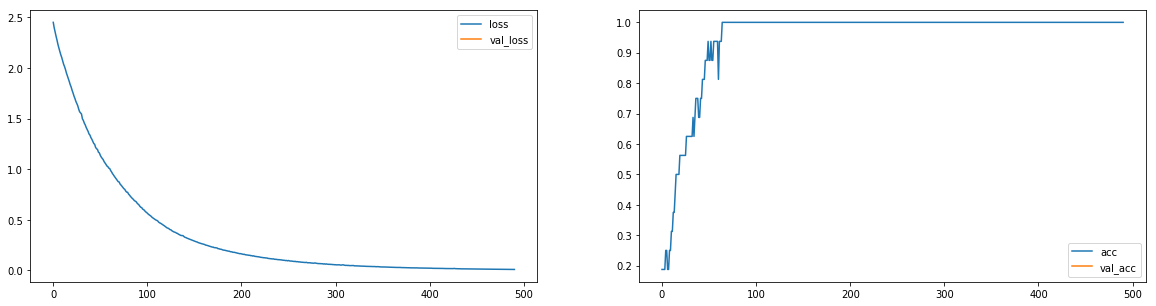

Epoch 492/500
16/16 [==============================] - 0s 8ms/step - loss: 0.0098 - acc: 1.0000
Epoch 493/500
16/16 [==============================] - 0s 8ms/step - loss: 0.0098 - acc: 1.0000
Epoch 494/500
16/16 [==============================] - 0s 8ms/step - loss: 0.0097 - acc: 1.0000
Epoch 495/500
16/16 [==============================] - 0s 8ms/step - loss: 0.0096 - acc: 1.0000
Epoch 496/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0097 - acc: 1.0000
Epoch 497/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0097 - acc: 1.0000
Epoch 498/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0094 - acc: 1.0000
Epoch 499/500
16/16 [==============================] - 0s 8ms/step - loss: 0.0096 - acc: 1.0000
Epoch 500/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0098 - acc: 1.0000


In [60]:
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_5.fit(X_coded,y_coded, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

In [61]:
to_predict = X_coded
print(to_predict.shape)
predicted = model_5.predict(to_predict)
for i, row in enumerate(predicted):
    idx = np.argmax(row)
    print(X_5[i], '->', indices_to_chars[idx], int(row[idx]*100)/100)

(16, 15, 11)
['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''] -> M 0.98
['', '', '', '', '', '', '', '', '', '', '', '', '', '', 'M'] -> A 0.98
['', '', '', '', '', '', '', '', '', '', '', '', '', 'M', 'A'] -> C 0.98
['', '', '', '', '', '', '', '', '', '', '', '', 'M', 'A', 'C'] -> H 0.98
['', '', '', '', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H'] -> I 0.99
['', '', '', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I'] -> N 0.99
['', '', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N'] -> E 0.99
['', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E'] ->   0.99
['', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' '] -> L 0.99
['', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L'] -> E 0.99
['', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E'] -> A 0.99
['', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A'] -> R 0.99
['', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A', '

### Ahora redefino modelo como stateful y cargo los pesos del anterior

In [62]:
batch_size=1
model_5s = Sequential()
model_5s.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_5s.add(Dense(len(chars), activation="softmax"))
model_5s.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (1, 10)                   220       
_________________________________________________________________
dense_7 (Dense)              (1, 11)                   121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [63]:
model_5s.set_weights(model_5.get_weights())

### Donde esta el maximo si ingreso ceros?

In [64]:
model_5s.reset_states()
to_predict = np.zeros((1,1,y_coded.shape[1]))
for i in range(20):
    predicted = model_5s.predict(to_predict)
    idx = np.argmax(predicted[0])
    print(i+1, to_predict, '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)

1 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> I 0.16
2 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> E 0.29
3 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.18
4 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> E 0.32
5 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> E 0.42
6 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> E 0.48
7 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.57
8 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.71
9 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.74
10 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.81
11 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.57
12 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.94
13 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.97
14 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.89
15 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.98
16 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.94
17 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.97
18 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.98
19 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.94
20 [[[0. 0. 0. 0. 0. 

Notar que el máximo esta en la posición 16 y es M (Luego de ingresar con 16 ceros)

In [65]:
model_5s.reset_states()
to_predict = np.zeros((1,1,y_coded.shape[1]))
for i in range(15):
    predicted = model_5s.predict(to_predict)
    idx = np.argmax(predicted[0])
    print(i+1, to_predict, '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)

1 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> I 0.16
2 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> E 0.29
3 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.18
4 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> E 0.32
5 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> E 0.42
6 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> E 0.48
7 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.57
8 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.71
9 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.74
10 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.81
11 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.57
12 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.94
13 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.97
14 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.89
15 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]] -> M 0.98


In [66]:
for i in range(16):
    to_predict = y_coded[i:i+1].reshape(1, 1, len(chars))
    predicted = model_5s.predict(to_predict)
    idx = np.argmax(predicted[0])
    print(to_predict, '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)

[[[0 0 0 0 0 0 0 0 1 0 0]]] -> A 0.74
[[[0 1 0 0 0 0 0 0 0 0 0]]] -> C 0.91
[[[0 0 1 0 0 0 0 0 0 0 0]]] -> H 0.96
[[[0 0 0 0 0 1 0 0 0 0 0]]] -> I 0.99
[[[0 0 0 0 0 0 1 0 0 0 0]]] -> N 0.99
[[[0 0 0 0 0 0 0 0 0 1 0]]] -> E 0.5
[[[0 0 0 1 0 0 0 0 0 0 0]]] ->   0.9
[[[1 0 0 0 0 0 0 0 0 0 0]]] -> L 0.7
[[[0 0 0 0 0 0 0 1 0 0 0]]] -> E 0.65
[[[0 0 0 1 0 0 0 0 0 0 0]]] -> A 0.96
[[[0 1 0 0 0 0 0 0 0 0 0]]] -> R 0.94
[[[0 0 0 0 0 0 0 0 0 0 1]]] -> N 0.8
[[[0 0 0 0 0 0 0 0 0 1 0]]] -> I 0.98
[[[0 0 0 0 0 0 1 0 0 0 0]]] -> N 0.99
[[[0 0 0 0 0 0 0 0 0 1 0]]] -> G 0.94
[[[0 0 0 0 1 0 0 0 0 0 0]]] -> N 0.64


Notar que esto no funciona del todo bien ya que aprende que despues de 16 ceros viene la M y que despues de 15 ceros mas una M viene una A

### Realimento salida
Pero no ingreso con one-hot sino con las predicciones

In [67]:
window_size=1
model_5s.reset_states()
to_predict = np.zeros((1,1,y_coded.shape[1]))
for i in range(15):
    predicted = model_5s.predict(to_predict)
    idx = np.argmax(predicted[0])
    #print(i+1, to_predict, '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)
#print(predicted.shape)
for i in range(16):
    to_predict = predicted.reshape(1, 1, len(chars))
    predicted = model_5s.predict(to_predict)
    idx = np.argmax(predicted[0])
    print((to_predict*100).astype(int)/100, '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)

[[[0.   0.   0.   0.   0.   0.   0.   0.   0.98 0.   0.  ]]] -> A 0.72
[[[0.   0.72 0.   0.01 0.   0.12 0.   0.01 0.09 0.   0.02]]] -> C 0.9
[[[0.   0.   0.9  0.   0.   0.04 0.   0.   0.   0.   0.03]]] -> H 0.96
[[[0.   0.   0.   0.   0.   0.96 0.   0.   0.   0.   0.  ]]] -> I 0.99
[[[0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.   0.  ]]] -> N 0.99
[[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]]] -> E 0.56
[[[0.   0.   0.03 0.56 0.24 0.   0.13 0.01 0.   0.   0.  ]]] ->   0.94
[[[0.94 0.   0.   0.   0.   0.   0.   0.   0.   0.05 0.  ]]] -> L 0.79
[[[0.   0.01 0.   0.   0.14 0.   0.03 0.79 0.   0.   0.  ]]] -> E 0.79
[[[0.09 0.   0.   0.79 0.   0.   0.   0.   0.   0.05 0.04]]] -> A 0.97
[[[0.   0.97 0.   0.   0.02 0.   0.   0.   0.   0.   0.  ]]] -> R 0.96
[[[0.   0.   0.01 0.   0.   0.   0.01 0.   0.   0.   0.96]]] -> N 0.71
[[[0.   0.   0.   0.   0.   0.26 0.   0.   0.   0.71 0.  ]]] -> I 0.99
[[[0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.   0.  ]]] -> N 0.99
[[[0.  

## Ejemplo 6: Masking

In [68]:
from keras.layers import Masking

### Armo modelo

In [69]:
model_6 = Sequential()
model_6.add(Masking(mask_value=0., input_shape=(X_coded.shape[1],X_coded.shape[2])))
model_6.add(SimpleRNN(10))
model_6.add(Dense(len(chars), activation="softmax"))
model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 15, 11)            0         
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 10)                220       
_________________________________________________________________
dense_8 (Dense)              (None, 11)                121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


### Lo entreno

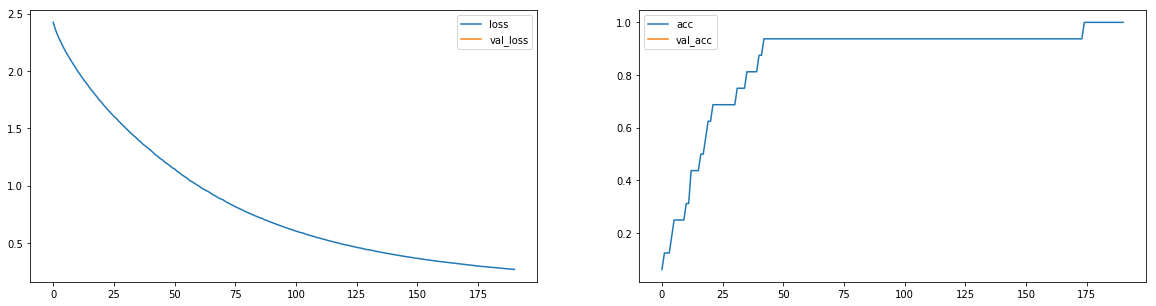

Epoch 192/200
16/16 [==============================] - 0s 9ms/step - loss: 0.2659 - acc: 1.0000
Epoch 193/200
16/16 [==============================] - 0s 9ms/step - loss: 0.2641 - acc: 1.0000
Epoch 194/200
16/16 [==============================] - 0s 8ms/step - loss: 0.2624 - acc: 1.0000
Epoch 195/200
16/16 [==============================] - 0s 8ms/step - loss: 0.2605 - acc: 1.0000
Epoch 196/200
16/16 [==============================] - 0s 8ms/step - loss: 0.2587 - acc: 1.0000
Epoch 197/200
16/16 [==============================] - 0s 9ms/step - loss: 0.2576 - acc: 1.0000
Epoch 198/200
16/16 [==============================] - 0s 9ms/step - loss: 0.2556 - acc: 1.0000
Epoch 199/200
16/16 [==============================] - 0s 8ms/step - loss: 0.2537 - acc: 1.0000
Epoch 200/200
16/16 [==============================] - 0s 8ms/step - loss: 0.2521 - acc: 1.0000


In [70]:
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_6.fit(X_coded,y_coded, epochs=200, batch_size=1, verbose=1, callbacks=[plot_losses])

### Resultados

In [71]:
to_predict = X_coded
predicted = model_6.predict(to_predict)
for i, row in enumerate(predicted):
    idx = np.argmax(row)
    print(X_5[i], '->', indices_to_chars[idx], int(row[idx]*100)/100)

['', '', '', '', '', '', '', '', '', '', '', '', '', '', ''] -> M 0.12
['', '', '', '', '', '', '', '', '', '', '', '', '', '', 'M'] -> A 0.8
['', '', '', '', '', '', '', '', '', '', '', '', '', 'M', 'A'] -> C 0.8
['', '', '', '', '', '', '', '', '', '', '', '', 'M', 'A', 'C'] -> H 0.86
['', '', '', '', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H'] -> I 0.92
['', '', '', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I'] -> N 0.93
['', '', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N'] -> E 0.82
['', '', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E'] ->   0.87
['', '', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' '] -> L 0.87
['', '', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L'] -> E 0.88
['', '', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E'] -> A 0.95
['', '', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A'] -> R 0.88
['', '', '', 'M', 'A', 'C', 'H', 'I', 'N', 'E', ' ', 'L', 'E', 'A', 'R'] -> N 0.91
[

### Armo modelo stateful y cargo pesos de modelo anterior entrenado

In [72]:
model_6s = Sequential()
model_6s.add(Masking(mask_value=0., batch_input_shape=(batch_size,1,len(chars))))
model_6s.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_6s.add(Dense(len(chars), activation="softmax"))
model_6s.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (1, 1, 11)                0         
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (1, 10)                   220       
_________________________________________________________________
dense_9 (Dense)              (1, 11)                   121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [73]:
model_6s.set_weights(model_6.get_weights())

In [74]:
# Comentar el reset_states y ver que pasa
# Entrenar 2 de 500 epochs

model_6s.reset_states()

for i in range(16):
    to_predict = y_coded[i:i+1].reshape(1, 1, len(chars))
    predicted = model_6s.predict(to_predict)
    idx = np.argmax(predicted[0])
    print(str(to_predict)+' '+text[i], '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)

[[[0 0 0 0 0 0 0 0 1 0 0]]] M -> A 0.8
[[[0 1 0 0 0 0 0 0 0 0 0]]] A -> C 0.8
[[[0 0 1 0 0 0 0 0 0 0 0]]] C -> H 0.86
[[[0 0 0 0 0 1 0 0 0 0 0]]] H -> I 0.92
[[[0 0 0 0 0 0 1 0 0 0 0]]] I -> N 0.93
[[[0 0 0 0 0 0 0 0 0 1 0]]] N -> E 0.82
[[[0 0 0 1 0 0 0 0 0 0 0]]] E ->   0.87
[[[1 0 0 0 0 0 0 0 0 0 0]]]   -> L 0.87
[[[0 0 0 0 0 0 0 1 0 0 0]]] L -> E 0.88
[[[0 0 0 1 0 0 0 0 0 0 0]]] E -> A 0.95
[[[0 1 0 0 0 0 0 0 0 0 0]]] A -> R 0.88
[[[0 0 0 0 0 0 0 0 0 0 1]]] R -> N 0.91
[[[0 0 0 0 0 0 0 0 0 1 0]]] N -> I 0.91
[[[0 0 0 0 0 0 1 0 0 0 0]]] I -> N 0.98
[[[0 0 0 0 0 0 0 0 0 1 0]]] N -> G 0.75
[[[0 0 0 0 1 0 0 0 0 0 0]]] G -> N 0.63


### Arrancando del medio

In [75]:
model_6s.reset_states()
st = 8
for i in range(5):
    to_predict = y_coded[i+st:i+st+1].reshape(1, 1, len(chars))
    predicted = model_6s.predict(to_predict)
    idx = np.argmax(predicted[0])
    print(str(to_predict)+' '+text[i+st], '->', indices_to_chars[idx], int(predicted[0][idx]*100)/100)

[[[0 0 0 0 0 0 0 1 0 0 0]]] L -> E 0.4
[[[0 0 0 1 0 0 0 0 0 0 0]]] E ->   0.56
[[[0 1 0 0 0 0 0 0 0 0 0]]] A -> C 0.41
[[[0 0 0 0 0 0 0 0 0 0 1]]] R -> H 0.44
[[[0 0 0 0 0 0 0 0 0 1 0]]] N -> I 0.86



### Ventajas/Desventajas entre este método y stateful
- Ventajas: Este metodo permite el entrenamiento de a batches de manera mas simple
- Desventajas: Si la secuencia es muy larga el unfolding termina siendo demasiado largo y requiere mas memoria y procesamiento

Nota: En stateful, dependiendo del problema, se puede entrenar con batch size mayor a uno pero hay que pensar bien el armado de las secuencias de entrenamiento.

Un ejemplo podría ser: Tengo que generar frases cortas de longitud variable y quiero que aprenda un modelo de lenguage para generar una frase corta

# 7 - Many to Many

In [76]:
inp = chars_to_one_hot(' MACHINE LEARNING', chars, chars_to_indices, window_size)*1
out = chars_to_one_hot('MACHINE LEARNING ', chars, chars_to_indices, window_size)*1

In [77]:
model_7 = Sequential()
model_7.add(SimpleRNN(10, input_shape=(inp.shape[1],inp.shape[2]), return_sequences=True))
model_7.add(Dense(len(chars), activation="softmax"))
model_7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 17, 10)            220       
_________________________________________________________________
dense_10 (Dense)             (None, 17, 11)            121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


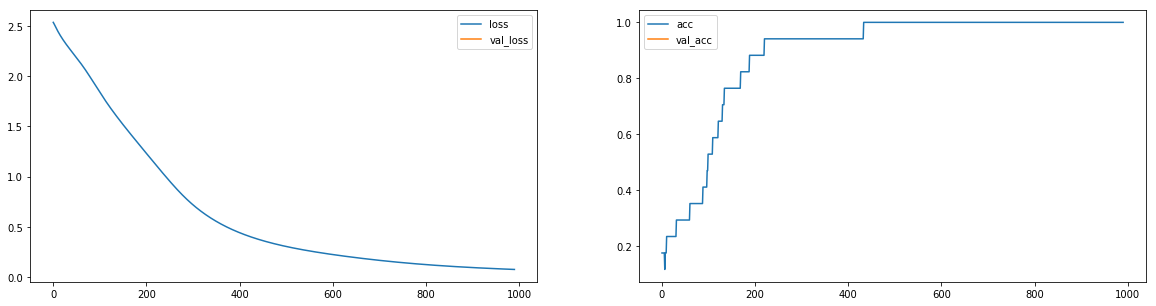

Epoch 992/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0760 - acc: 1.0000
Epoch 993/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0759 - acc: 1.0000
Epoch 994/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0757 - acc: 1.0000
Epoch 995/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.0755 - acc: 1.0000
Epoch 996/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0753 - acc: 1.0000
Epoch 997/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0752 - acc: 1.0000
Epoch 998/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0750 - acc: 1.0000
Epoch 999/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0748 - acc: 1.0000
Epoch 1000/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.0747 - acc: 1.0000


In [78]:
model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_7.fit(inp,out, epochs=1000, batch_size=1, verbose=1, callbacks=[plot_losses])

In [79]:
# batch_size=1
model_7s = Sequential()
model_7s.add(SimpleRNN(10, batch_input_shape=(1,1,inp.shape[2]), stateful=True, return_sequences=True))
model_7s.add(Dense(len(chars), activation="softmax"))
model_7s.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (1, 1, 10)                220       
_________________________________________________________________
dense_11 (Dense)             (1, 1, 11)                121       
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [80]:
model_7s.set_weights(model_7.get_weights())

In [81]:
# Probar con 0, 3, 4, 7 y 1
starting = 4
model_7s.reset_states()
for c in text[starting:]:
    to_predict = chars_to_one_hot(c, chars, chars_to_indices, window_size)*1
    predicted = model_7s.predict(to_predict)
    print(c, '->', indices_to_chars[np.argmax(predicted[0])], int(np.max(predicted[0])*100)/100)

I -> N 0.61
N -> E 0.83
E ->   0.74
  -> L 0.79
L -> E 0.92
E -> A 0.94
A -> R 0.89
R -> N 0.92
N -> I 0.97
I -> N 0.93
N -> G 0.81
G ->   0.96


## Ejemplo 7: Return sequence

In [82]:
text="#MACHINE LEARNING$"
chars = sorted(set(text))
print('Caracteres distintos:')
print(chars)
window_size=1
chars_to_indices = dict((c, i) for i, c in enumerate(chars))  # map each unique character to unique integer
indices_to_chars = dict((i, c) for i, c in enumerate(chars))
one_hot_text = chars_to_one_hot(text, chars, chars_to_indices, window_size)*1
print(one_hot_text)
print(one_hot_text.shape)

Caracteres distintos:
[' ', '#', '$', 'A', 'C', 'E', 'G', 'H', 'I', 'L', 'M', 'N', 'R']
[[[0 1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 1 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0 0]]]
(1, 18, 13)


In [83]:
X_train = one_hot_text[:, :-1, :]
y_train = one_hot_text[:, 1:, :]

In [84]:
X_train.shape, y_train.shape

((1, 17, 13), (1, 17, 13))

In [85]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential
model_7 = Sequential()
model_7.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1],len(chars))))
model_7.add(Dense(len(chars), activation="softmax"))
model_7.summary()

NameError: name 'LSTM' is not defined

In [ ]:
model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_7.fit(X_train,y_train, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

In [ ]:
X_train.shape

In [ ]:
model_7.predict(X_train).shape

In [ ]:
model_7.predict_classes(X_train)

In [ ]:
indices_to_chars

# Encoder decoder
https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/

# Sentiment analysis con CNN y LSTM
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

# Word-level language model

https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

# return_sequence vs return_state
https://www.quora.com/What-is-the-difference-between-states-and-outputs-in-LSTM

https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

# Truncated BPTT 
https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/